<a href="https://colab.research.google.com/github/spencer18001/Clustering-And-Dimensionality-Reduction---Deep-Dive/blob/main/10/1021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!apt install libcairo2-dev pkg-config python3-dev
!pip install hdbscan igraph leidenalg cairocffi

## HDBSCAN custom implementation

In [2]:
# !{sys.executable} -m pip install hdbscan
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan

from sklearn.neighbors import NearestNeighbors

from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform

from scipy.cluster.hierarchy import dendrogram
import igraph as ig # we will use to obtain minimum spanning trees and to also display them

sns.set_theme()

HDBSCAN main steps:

1. **Calculate core and reachability distances**

2. **Build the minimum spanning tree from the fully connected graph, which is created by using mutual reachability distances**

3. **Build dendrogram from MST**

4. **Condense the dendrogram based on minimum cluster size**

5. **Extract the stable clusters from the condensed tree**


Steps 1-3 are implemented from scratch. HDBSCAN python library is used to carry out steps 4 & 5.

### Create the dataset

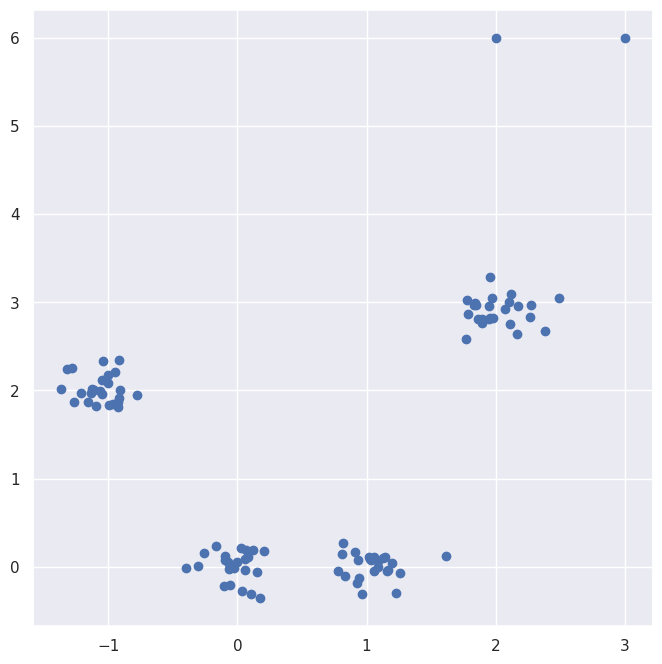

In [3]:
plt.rcParams["figure.figsize"] = (8,8)

# Create test data
X, y = make_blobs(
    n_samples=100,
    centers=[(-1,2), (0, 0), (2,2.9), [1,0]],
    cluster_std=0.15,
    random_state=2
)

# Add two outliers
X = np.vstack([X, np.array([[2,6],[3,6]])])
y = np.concatenate([y, np.array([-1,-1])])

plt.scatter(X[:,0], X[:,1])
# we have four clusters and two outlier data points

### Set hdbscan parameters

In [4]:
### HDBSCAN parameters
MIN_SAMPLES = 5

### Step 1 - compute mutual reachability

In [5]:
# Calculate distances between points
dists = pdist(X, metric='euclidean')
dists = squareform(dists)

# Fit the nn object
nn_obj = NearestNeighbors(metric='precomputed')
nn_obj = nn_obj.fit(dists)

In [6]:
# Find core distance as distance to nth neighbor
# we are introducing plus one because we want a distance to the kth nearest neighbor,
# and we want to account for a data point being its own nearest neighbor
distances, neigh_ids = nn_obj.kneighbors(dists, n_neighbors=MIN_SAMPLES+1)
core_dists = distances[:, -1]

# Find mutual reachability distance by using regular distances and core distances
reach_dists = np.max(
    [dists, *np.meshgrid(core_dists, core_dists)],
    axis=0
)

### Step 2 - minimum spanning tree

In [7]:
# we will use the Igraph library in order to create a graph from our mutual reachability
# we will treat mutual reachability distances as an adjacency matrix of a weighted undirected graph
# then we will use Igraph to find the minimum spanning tree to obtain the adjacency matrix of the minimum spanning tree, which ultimately represents a subset of this original adjacency matrix
# finally, we will go on and transform this adjacency matrix back to the numpy array format

g = ig.Graph.Weighted_Adjacency(reach_dists, mode='undirected')

# Find the minimum spanning tree
mst = g.spanning_tree(weights=g.es["weight"])
mst_adj = mst.get_adjacency(attribute='weight')
MST = np.array(mst_adj.data)

In [8]:
# we will use these two cells as a black box in order to plot the minimum spanning tree
# all of this code will become a much clearer in the next chapter where we will actually learn about igraph

# Original MST contains distances, in order to create graph
# we need ajdacency matrix where high values mean high connectivity
# which is oposite from distance
plot_MST = MST.copy()
plot_MST[plot_MST == 0] = np.inf
plot_MST = 1/plot_MST

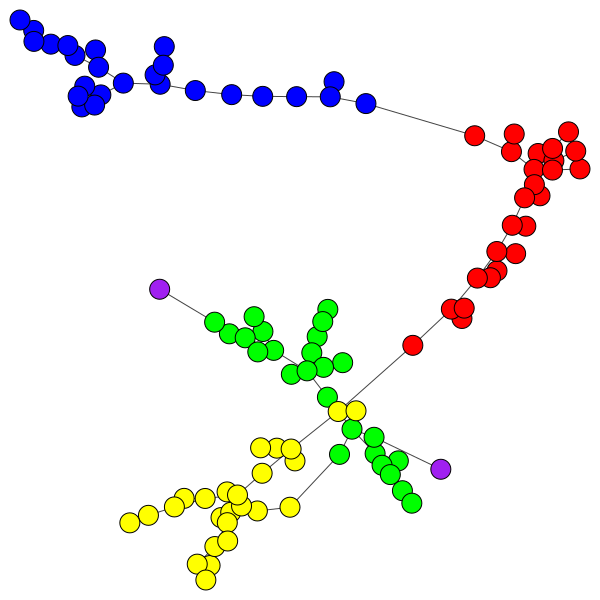

In [9]:
# Use igraph to plot MST
# This is similar to the second phase of UMAP
property_dict = {0: 'blue', 1: 'red', 2: 'green', 3: 'yellow', -1: 'purple'}
node_colors = [property_dict[curr_y] for curr_y in y]

plot_g = ig.Graph.Weighted_Adjacency(plot_MST, mode='undirected')
plot_g.vs['color'] = node_colors

layout = plot_g.layout("auto", weights='weight')
ig.plot(plot_g, layout=layout)
# this minimum spanning tree is very useful when it comes to separating our clusters
# all we have to do is to cut a couple of right connections,
# and this will result in each group representing a single cluster or a single noise data point of our data

### Step 3 - Building cluster hierarchy

In [10]:
# Convert adjacency matrix of MST to a list of edges with distances
edges = []
for i in range(MST.shape[0]):
    for j in range(i+1, MST.shape[1]):
        if MST[i, j] != 0:
            edges.append((i, j, MST[i, j]))

edges[:4]

[(0, 6, 0.3029035430877053),
 (0, 23, 0.275203396350211),
 (0, 25, 0.1881718605278406),
 (0, 71, 0.13156414465886548)]

In [11]:
# Sort edges by distance from lowest to highest
edges.sort(key=lambda x: x[2], reverse=False)

edges[:4]

[(30, 94, 0.05640646975133554),
 (4, 13, 0.06416412366853207),
 (13, 30, 0.06416412366853207),
 (94, 99, 0.06733065069145353)]

In [12]:
# Create dataframe from edges
edges_df = pd.DataFrame(edges, columns=['p1', 'p2', 'dist'])
edges_df

,p1,p2,dist
0,30,94,0.056406
1,4,13,0.064164
2,13,30,0.064164
3,94,99,0.067331
4,18,28,0.072765
...,...,...,...
96,20,81,0.608050
97,2,79,1.749153
98,11,68,2.469098
99,87,100,2.981358


In [13]:
# Initialize groups_dict (each point gets a cluster)
groups = {i:[i] for i in range(MST.shape[0])} # (group->data_points)

groups

{0: [0],
 1: [1],
 2: [2],
 3: [3],
 4: [4],
 5: [5],
 6: [6],
 7: [7],
 8: [8],
 9: [9],
 10: [10],
 11: [11],
 12: [12],
 13: [13],
 14: [14],
 15: [15],
 16: [16],
 17: [17],
 18: [18],
 19: [19],
 20: [20],
 21: [21],
 22: [22],
 23: [23],
 24: [24],
 25: [25],
 26: [26],
 27: [27],
 28: [28],
 29: [29],
 30: [30],
 31: [31],
 32: [32],
 33: [33],
 34: [34],
 35: [35],
 36: [36],
 37: [37],
 38: [38],
 39: [39],
 40: [40],
 41: [41],
 42: [42],
 43: [43],
 44: [44],
 45: [45],
 46: [46],
 47: [47],
 48: [48],
 49: [49],
 50: [50],
 51: [51],
 52: [52],
 53: [53],
 54: [54],
 55: [55],
 56: [56],
 57: [57],
 58: [58],
 59: [59],
 60: [60],
 61: [61],
 62: [62],
 63: [63],
 64: [64],
 65: [65],
 66: [66],
 67: [67],
 68: [68],
 69: [69],
 70: [70],
 71: [71],
 72: [72],
 73: [73],
 74: [74],
 75: [75],
 76: [76],
 77: [77],
 78: [78],
 79: [79],
 80: [80],
 81: [81],
 82: [82],
 83: [83],
 84: [84],
 85: [85],
 86: [86],
 87: [87],
 88: [88],
 89: [89],
 90: [90],
 91: [91],
 92: [92

In [14]:
# Initialize linkage matrix
linkage_matrix = []

# Next id for newly formed groups (merges)
next_id = MST.shape[0]

# Iterate through the edges
for idx in edges_df.index:
    # Iterate through all of the existing groups
    for k in groups:
        # Find cluster containing p1
        if edges_df.loc[idx, 'p1'] in groups[k]:
            cluster_i = k
        # Find cluster containing p2
        if edges_df.loc[idx, 'p2'] in groups[k]:
            cluster_j = k

    # If points do not belong to same cluster then
    # merge groups containing this points
    if cluster_i != cluster_j:
        # Add cluster merge to linkage matrix (this if  statement controls
        # order of p1 and p2 in linkage the matrix)
        # This is done to make dendrogram look better
        # (clustering would work even without this step)
        if len(groups[cluster_i])> len(groups[cluster_j]):
            linkage_matrix.append(
                [cluster_j, cluster_i, edges_df.loc[idx, 'dist'],
                len(groups[cluster_i]) + len(groups[cluster_j])]
            )
        else:
            linkage_matrix.append(
                [cluster_i, cluster_j, edges_df.loc[idx, 'dist'],
                len(groups[cluster_i]) + len(groups[cluster_j])]
            )

        # Create merged cluster
        groups[next_id] = groups[cluster_i] + groups[cluster_j]

        # Delete processed groups
        del groups[cluster_i], groups[cluster_j]

        # Increment cluster id
        next_id +=1

linkage_matrix[:10]
# after all the iterations are done, we will get this list of lists, which is basically an adjacency matrix
# so we have the id of the first element, id of the second element, the distance and the size of the new group

[[30, 94, 0.05640646975133554, 2],
 [4, 13, 0.06416412366853207, 2],
 [103, 102, 0.06416412366853207, 4],
 [99, 104, 0.06733065069145353, 5],
 [18, 28, 0.07276490379068959, 2],
 [91, 106, 0.0761243211903352, 3],
 [33, 107, 0.07842321382462053, 4],
 [69, 108, 0.07842321382462053, 5],
 [84, 105, 0.08828725545014618, 6],
 [85, 109, 0.08928159966520095, 6]]

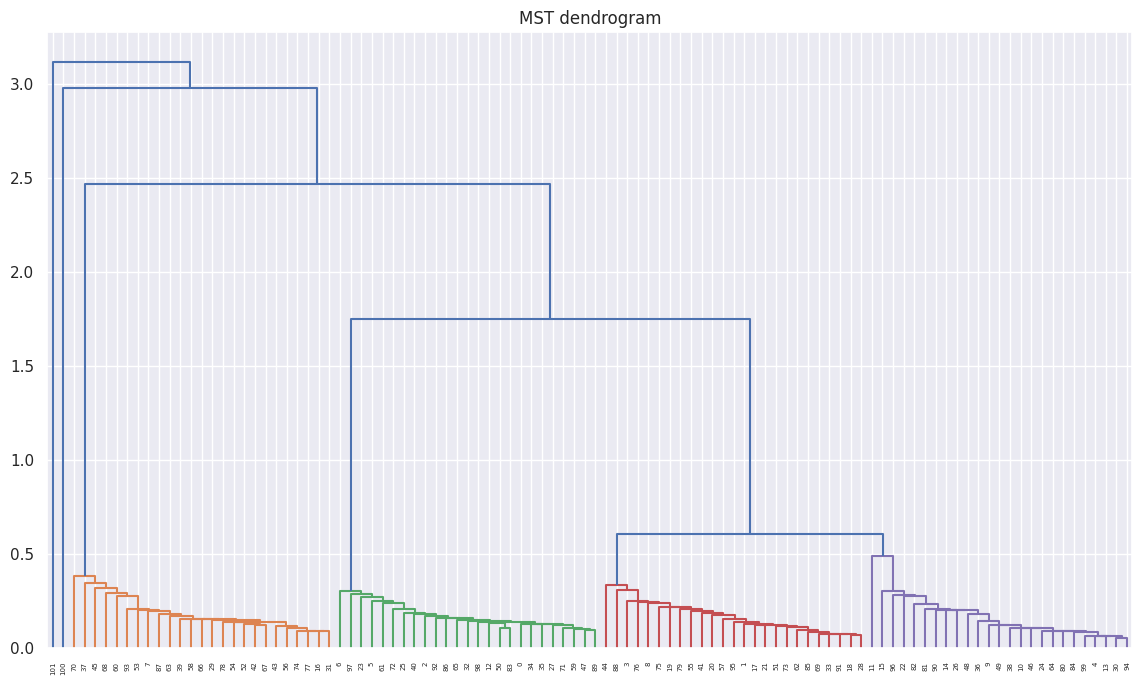

In [15]:
# Convert linkage_matrix to the format required by scipy dendrogram
linkage_matrix = np.array(linkage_matrix)

# Set figure size for dendrogram
plt.rcParams["figure.figsize"] = (16,8)

# Plot the dendrogram
plt.figure(figsize=(14,8))
dendrogram(linkage_matrix,color_threshold=0.5)
plt.title('MST dendrogram')
plt.show()
# all the groups are clearly visible
# we have this nice branch structure because of our earlier effort
# where we have always made sure to first add the smaller group and then the bigger group

## Part 2 - HDBSCAN package

In [16]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,
    min_samples=5,
    gen_min_span_tree=True,
    metric='euclidean',
    approx_min_span_tree=False
)
clusterer = clusterer.fit(X)

<Axes: >

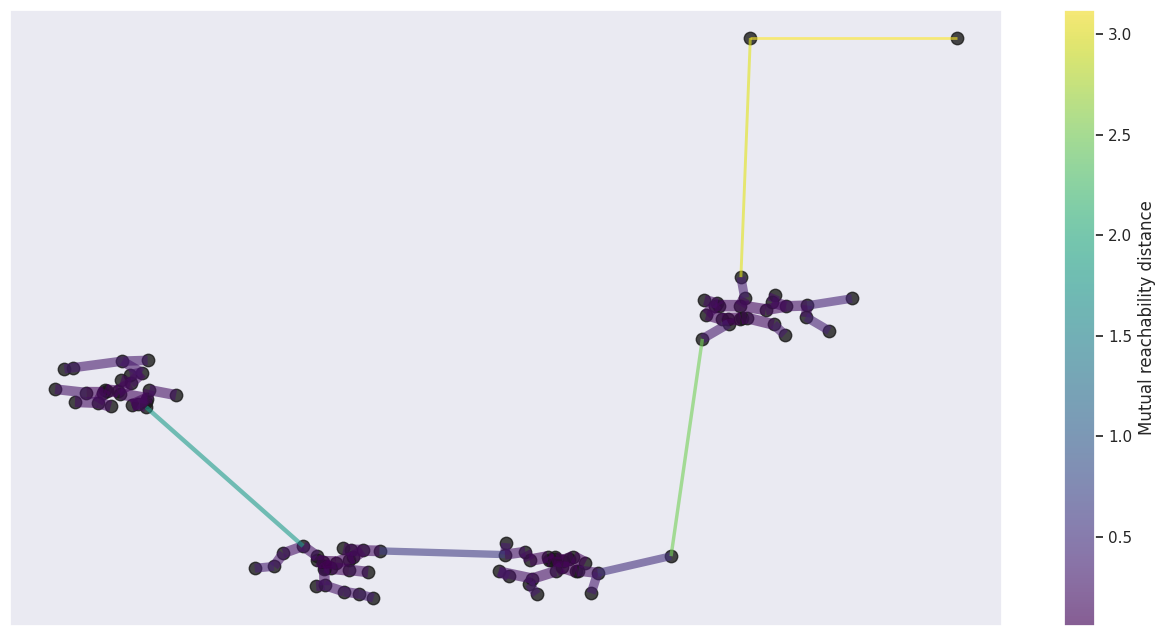

In [17]:
# Plot minimum spanning tree
clusterer.minimum_spanning_tree_.plot(
    edge_cmap='viridis',
    edge_alpha=0.6,
    node_size=80,
    edge_linewidth=2
)

<Axes: ylabel='distance'>

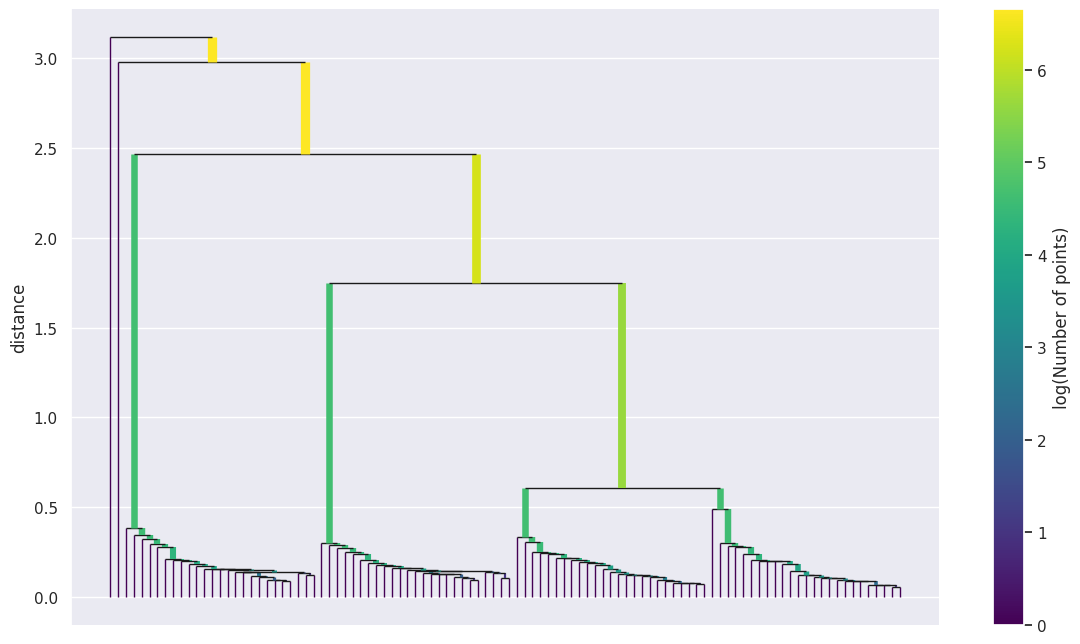

In [18]:
# Plot dendrogram
plt.figure(figsize=(14,8))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

Text(0.5, 1.0, 'min_cluster_size = 4')

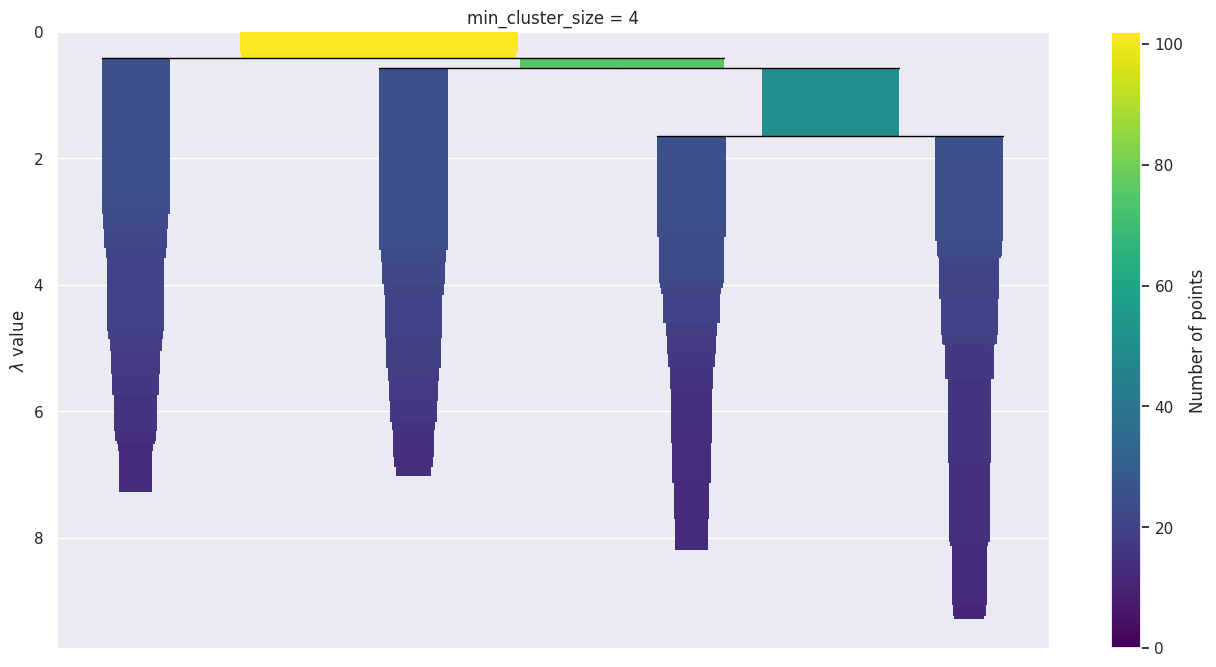

In [19]:
# Condensed tree plot
clusterer.condensed_tree_.plot()
plt.title('min_cluster_size = 4')

Text(0.5, 1.0, 'Same setup witn min_cluster_size=2')

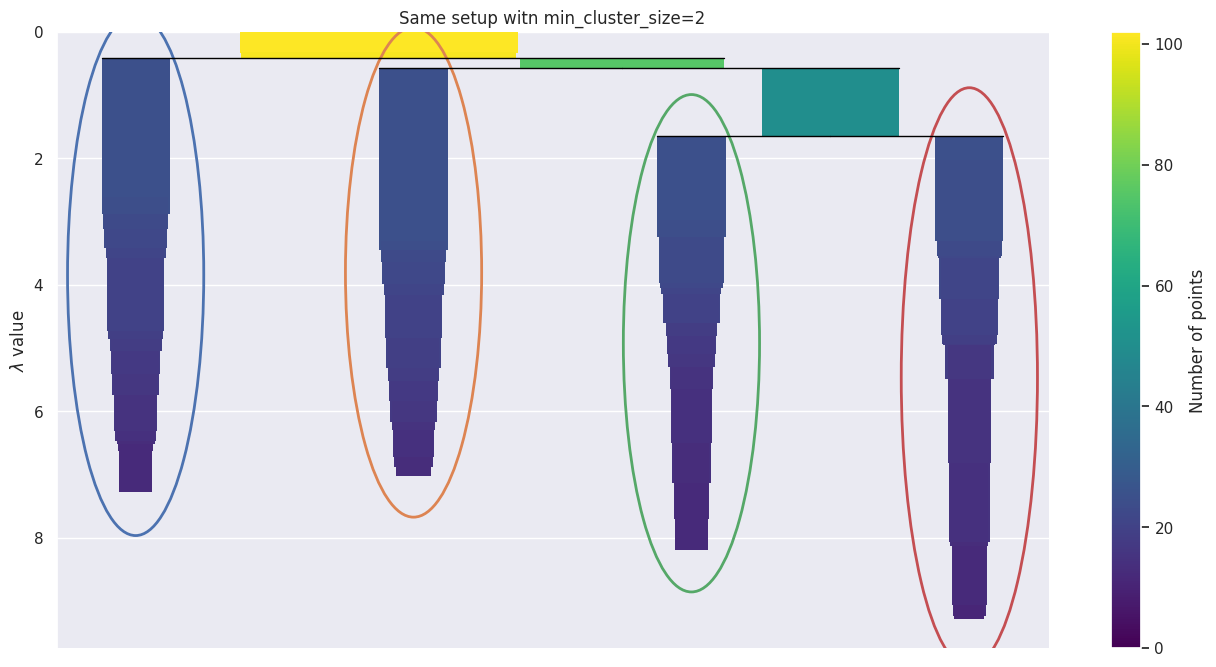

In [20]:
# Selected clusters
# excess of mass
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.title('Same setup witn min_cluster_size=2')

In [21]:
clusterer.labels_
# we have four different clusters and two noise data points

array([ 1,  2,  1,  2,  3,  1,  1,  0,  2,  3,  3,  3,  1,  3,  3,  3,  0,
        2,  2,  2,  2,  2,  3,  1,  3,  1,  3,  1,  2,  0,  3,  0,  1,  2,
        1,  1,  3,  0,  3,  0,  1,  2,  0,  0,  2,  0,  3,  1,  3,  3,  1,
        2,  0,  0,  0,  2,  0,  2,  0,  1,  0,  1,  2,  0,  3,  1,  0,  0,
        0,  2,  0,  1,  1,  2,  0,  2,  2,  0,  0,  2,  3,  3,  3,  1,  3,
        2,  1,  0,  2,  1,  3,  2,  1,  0,  3,  2,  3,  1,  1,  3, -1, -1])

<Axes: >

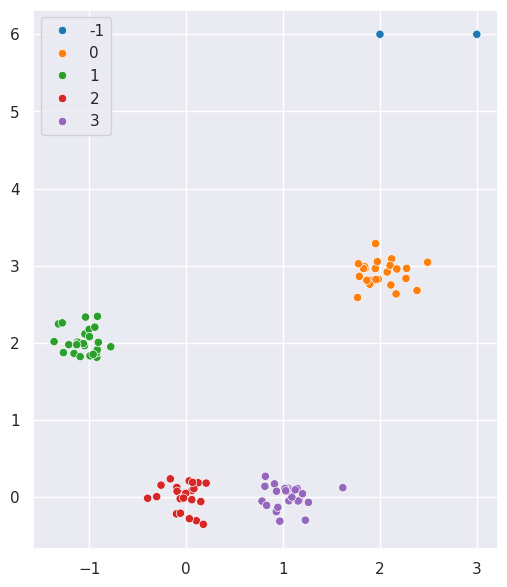

In [22]:
# Final clustering results
plt.figure(figsize=(6,7))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=clusterer.labels_, palette='tab10')
# we have managed to discover both clusters and outliers

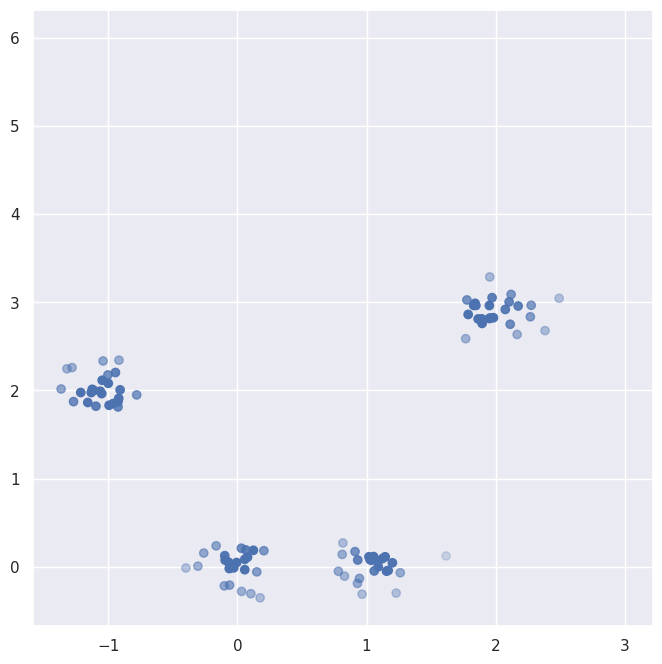

In [23]:
plt.rcParams["figure.figsize"] = (8,8)

plt.scatter(X[:,0], X[:,1], alpha=clusterer.probabilities_)
# I also want to show you how you can use cluster probabilities in order to find data points that are located in the core of the cluster
# so if we do this, you can see that we have brighter colors for data points that are central to each of these clusters

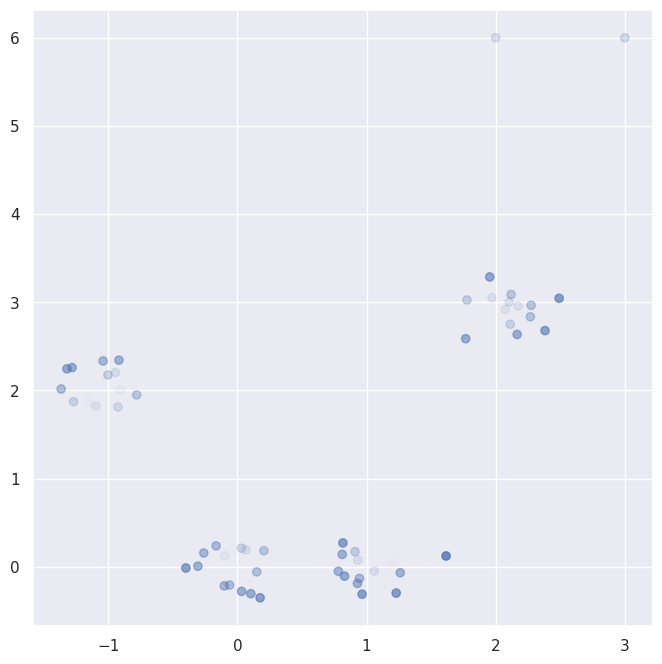

In [24]:
plt.rcParams["figure.figsize"] = (8,8)

plt.scatter(X[:,0], X[:,1], alpha=clusterer.outlier_scores_)
# we can also use the outlier scores attribute in order to check how outlier like are our data points
# and this is not applied to our actual outliers
# but again you can see that the data points on the uh cluster edges are more outlier like

### Using cluster_selection_epsilon

<Axes: >

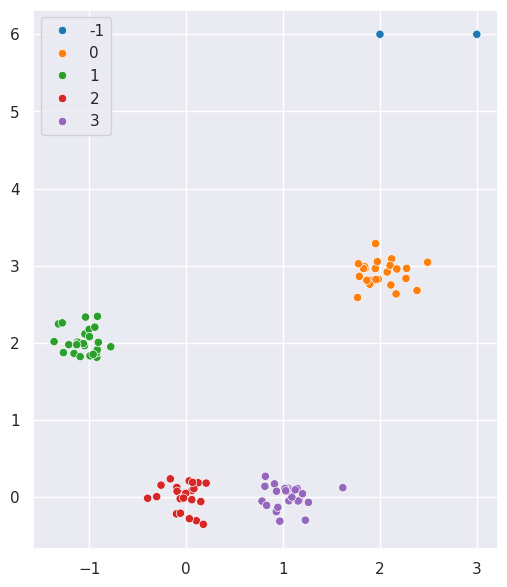

In [25]:
# Before cluster_selection_epsilon
plt.figure(figsize=(6,7))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=clusterer.labels_, palette='tab10')
# let's say that we want to merge these two clusters (red, purple)

In [26]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,
    min_samples=5,
    gen_min_span_tree=True,
    metric='euclidean',
    approx_min_span_tree=False,
    cluster_selection_epsilon=1.5
)
clusterer = clusterer.fit(X)

<Axes: >

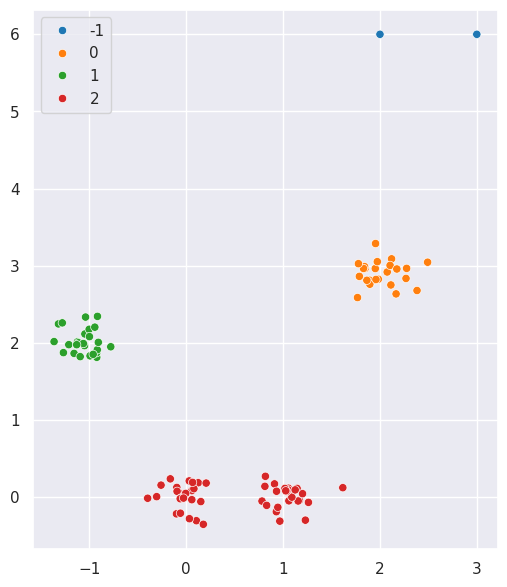

In [27]:
# After cluster_selection_epsilon
plt.figure(figsize=(6,7))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=clusterer.labels_, palette='tab10')
# this will partially override the excess of mass
# and you can see that now these two groups represent a single cluster

### Leaf clustering

Text(0.5, 1.0, 'Same setup witn min_cluster_size=2')

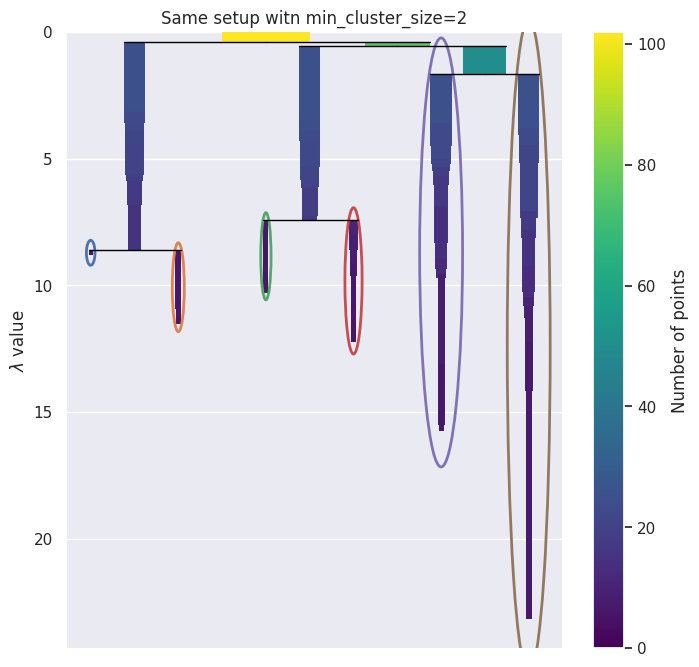

In [28]:
# in order to better demonstrate this we will create another condensed tree which has different settings and higher number of branches
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=3,
    gen_min_span_tree=True,
    metric='euclidean',
    approx_min_span_tree=False,
    cluster_selection_method='leaf'
)
clusterer = clusterer.fit(X)

clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.title('Same setup witn min_cluster_size=2')
# all the leafs of the condensed tree are selected as clusters, which can be useful if you want higher cross if you want higher clustering granularity

<Axes: >

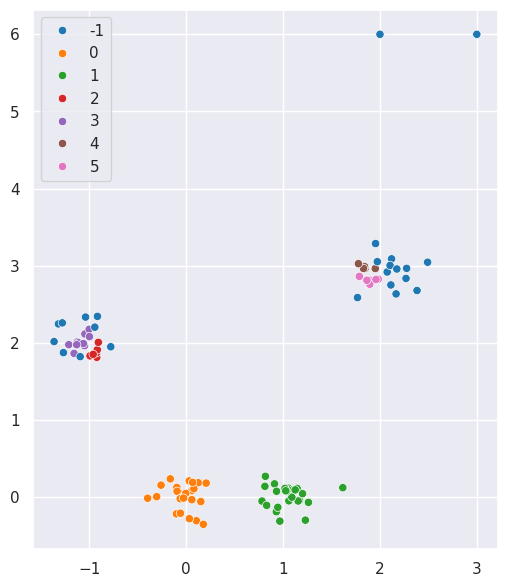

In [29]:
plt.figure(figsize=(6,7))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=clusterer.labels_, palette='tab10')
# as you can see uh this clusters got splitted
# and we have higher number of noise data points

<Axes: >

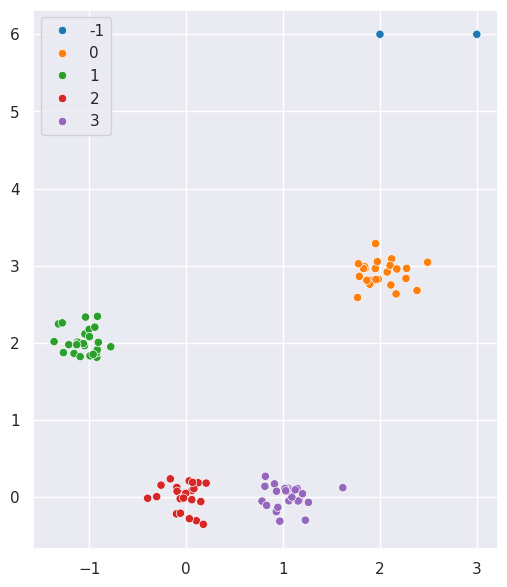

In [30]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,
    min_samples=3,
    gen_min_span_tree=True,
    metric='euclidean',
    approx_min_span_tree=False,
    cluster_selection_method='leaf',
    cluster_selection_epsilon=0.5
)
clusterer = clusterer.fit(X)

plt.figure(figsize=(6,7))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=clusterer.labels_, palette='tab10')
# if you want to control the granularity in this case you can also use the cluster selection epsilon
# and the clusters that are closer than this distance will not be splitted